# **Random Signal Processing**
This notebook creates an SVM machine that classifies between Male and Female voices in audio records.
The dataset is MP3 files, classified as Male/Female, and the waveforms of the MP3 files are proccesed using MFCC.
Some calibrations and tests are performed on the Dev set to improve the machine accuracy.


Final result on the **Test** set is: **97.5%**







# Preproccessing the data (Localy, on a PC)




In [ ]:
%%script echo skipping
# Preproccessing the data localy, PART 1
# Our dataset includes over 200k samples, which we couldn't upload to Google Drive
# We filtered the data and took the best samples available (by user votes)
# The original dataset can be found here: https://www.kaggle.com/mozillaorg/common-voice?select=cv-valid-test.csv

# RUN THIS LOCALY ONCE TO CREATE FILTERED DATASET CSV
# Input - dataset.csv and mp3 files, output - filtered dataset.csv and mp3 files

import pandas as pd                 # DataFrames
from sklearn.utils import resample  # Resampling unbalanced data
import shutil                       # Copying files
from tqdm import tqdm               # Progress bar .apply
tqdm.pandas()


# Over/Under sampling the dataset, user choice
def resampling_dataset(df, oversamp, grp_one, grp_two):
    """Over/under sample data for machine learning train data"""
    # separate minority and majority classes
    if oversamp:
        to_fix_df = df[df['gender'] == grp_one]
        desired_len_df = df[df['gender'] == grp_two]
    else:
        desired_len_df = df[df['gender'] == grp_one]
        to_fix_df = df[df['gender'] == grp_two]

    # resample, random_state for const results in every run
    pos_resampled = resample(to_fix_df, replace=True,
                             n_samples=len(desired_len_df), random_state=42)

    # combine desired_df_len and resampled
    df = pd.concat([desired_len_df, pos_resampled])

    return df


if __name__ == "__main__":
    path = r"C:/"
    all_df = pd.read_csv(path + "cv-valid-train.csv")
    all_df.drop(['text', 'age', 'accent', 'duration'], axis=1, inplace=True)

    filter_1 = (all_df["down_votes"] == 0)
    filter_2 = (all_df["up_votes"] > 1)
    filter_f = (all_df["gender"] == "female")
    filter_m = (all_df["gender"] == "male")

    female_df = all_df[filter_1 & filter_2 & filter_f]
    male_df = all_df[filter_1 & filter_2 & filter_m]

    female_df = female_df.drop(axis=1, columns=['up_votes', 'down_votes'])
    male_df = male_df.drop(axis=1, columns=['up_votes', 'down_votes'])

    del filter_1, filter_2, filter_m, filter_f, all_df

    frames = female_df, male_df
    df = pd.concat(frames)

    df = resampling_dataset(df, oversamp=False, grp_one='female', grp_two='male')

    dest_folder = r"C:/Users/Tomer/Dropbox/RPex2/"
    df.to_csv(dest_folder + "dataset_filtered.csv", index=False)
    # Separate filtered files for easy copy
    df["filename"].progress_apply(lambda x: shutil.copy(src=path + x, dst=dest_folder))

skipping


In [ ]:
%%script echo skipping
# Preproccessing the data localy, PART 2

# RUN THIS LOCALY ONCE TO CREATE FILTERED DATASET CSV
# input - dataset csv, output - feature_vectores csv

import pandas as pd                         # Dataframes
import numpy as np                          # Advanced calcs
from dask.diagnostics import ProgressBar    # Progress bar
from pydub import AudioSegment, silence     # Preprocessing data
from librosa.feature import mfcc            # MFCC
from scipy.stats import skew                # Statistics
from sklearn.preprocessing import scale     # Normalize data
import dask.dataframe as dd                 # Multithreading
ProgressBar().register()


# Preprocessing the Audio files, cuts out silent parts over 0.5 sec
def cut_out_silence(audio_file):
    chunks = silence.split_on_silence(audio_file, silence_thresh=-50, min_silence_len=500, keep_silence=100)

    output_chunks = AudioSegment.empty()
    for chunk in chunks:
        output_chunks += chunk

    return output_chunks


# MFCC and data processing to create Feature Vector
def get_feature_vector(name, path, filt_num):
    # Load MP3 file, cut and set as array
    audio_data = AudioSegment.from_mp3(path + name)
    try:
        audio_data = cut_out_silence(audio_data)
        sr = audio_data.frame_rate
        audio_data = np.frombuffer(audio_data.get_array_of_samples(), dtype=np.int16)

        # Preprocessing - scaling data ((x-mean)/std)
        audio_data = scale(audio_data)

        # MFCC
        mfccs = mfcc(y=audio_data, sr=sr, n_mfcc=filt_num, fmin=100, fmax=6800)

        # We need a feature vector (1xconst_size) for all recordings
        # by applying some statistics calculations we can create this vector
        feat_vec = np.hstack((np.mean(mfccs, axis=1), np.std(mfccs, axis=1), skew(mfccs, axis=1),
                              np.max(mfccs, axis=1), np.median(mfccs, axis=1), np.min(mfccs, axis=1)))
        return pd.Series(feat_vec)

    except:
        # print('\n' + name)
        return pd.Series([0]*(filt_num*6))


if __name__ == "__main__":
    path = r"C:/Users/Tomer/Dropbox/RPex2/"
    df = pd.read_csv(path + "dataset_filtered.csv")

    df['gender'] = df['gender'].map({'male': 0, 'female': 1}).astype(int)
    d_data = dd.from_pandas(df, npartitions=64)

    filt_num = 13   # Test number 1
    res = d_data.map_partitions(lambda ddf: ddf['filename'].apply(get_feature_vector, path=path, filt_num=filt_num), meta=pd.DataFrame(columns=range(0, filt_num*6))).compute(scheduler='multiprocessing')
    res.to_csv(f"{path}/feature_vectors_librosa_13.csv", index=False)

skipping


# Imports

In [ ]:
import pandas as pd                                   # Dataframes
import numpy as np                                    # Advanced calcs

import matplotlib.pyplot as plt                       # Plotting, Imshow
# %matplotlib inline

from sklearn.preprocessing import scale               # Normalize data
from sklearn.model_selection import train_test_split  # Split data
from sklearn.svm import SVC                           # Machine learning
from sklearn.model_selection import GridSearchCV      # Grid Search
from sklearn.metrics import ConfusionMatrixDisplay    # Plotting
from sklearn.metrics import DetCurveDisplay           # Plotting

# Functions

## Handling the data

In [ ]:
def get_data(csv_file, test_prc):
  x_data = pd.read_csv(path + csv_file)
  y_data = pd.read_csv(path + 'feature_vectors_y.csv')

  # Clean [0]'s vectors - "bad files"
  del_ind = x_data[(x_data==0).all(axis=1)].index
  x_data.drop(del_ind, inplace=True)
  y_data.drop(del_ind, inplace=True)

  # Scaling before training the machine
  x_data_scale = scale(x_data)

  # Raveling values for training the machine
  y_data = y_data.values.ravel()

  # Split the dataset: train, test + dev
  x_train, x_test, y_train, y_test = train_test_split(x_data_scale, y_data, test_size=test_prc*2, random_state=42)
  # Split the train set: train and dev
  x_test, x_dev, y_test, y_dev = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

  return x_train, x_dev, x_test, y_train, y_dev, y_test

## Results and Graphs

In [ ]:
def results_graphs(test_name ,clf, x_set, y_set):
  score = clf.score(x_set, y_set)
  print(test_name)
  print("Test accuracy: " + str(score))

  ConfusionMatrixDisplay.from_estimator(clf, x_set, y_set)
  plt.title("Confusion Matrix")

  DetCurveDisplay.from_estimator(clf, x_set, y_set)
  plt.title("DET Curve")

  return score

# Grant access to Google Drive

In [ ]:
# Import dataframe and audio files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Important Variables

In [ ]:
path = r'drive/MyDrive/Colab Notebooks/'
test_prc = 0.15

# Machine Learning

Default values
Test accuracy: 0.9729632299927902


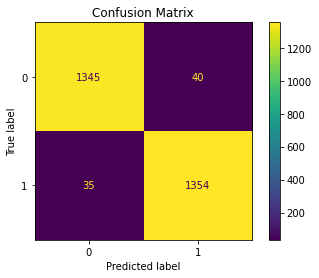

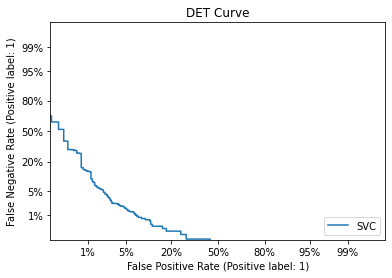

In [ ]:
# default - kernel = 'rbf', filters = 26, c = 1, gamma = 1/(n_features * X.var())
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n26.csv', test_prc)

lucas = SVC() 
lucas.fit(x_train, y_train)

filt_26_score = results_graphs("Default values", lucas, x_dev, y_dev)
rbf_score = filt_26_score

# **Test #1** - Filters bank

## 13 Filters

13 Filters
Test accuracy: 0.9354722422494592


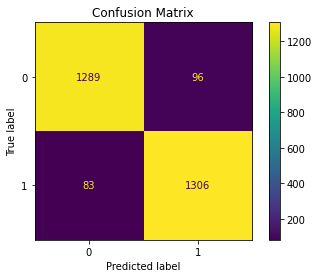

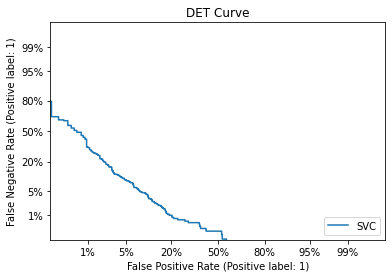

In [ ]:
# kernel = 'rbf', filters = 13, c = 1, gamma = 1/(n_features * X.var())
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n13.csv', test_prc)

lucas = SVC() 
lucas.fit(x_train, y_train)

filt_13_score = results_graphs("13 Filters", lucas, x_dev, y_dev)

## 40 Filters

40 Filters
Test accuracy: 0.9744051910598414


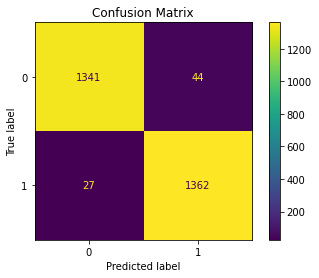

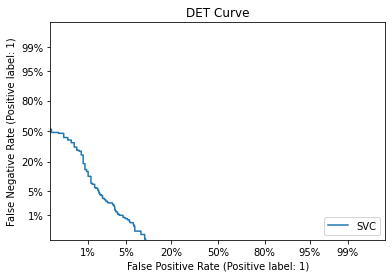

In [ ]:
# kernel = 'rbf', filters = 40, c = 1, gamma = 1/(n_features * X.var())
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n40.csv', test_prc)

lucas = SVC() 
lucas.fit(x_train, y_train)

filt_40_score = results_graphs("40 Filters", lucas, x_dev, y_dev)

## **Comparison**

In [ ]:
comp_list = [filt_13_score, filt_26_score, filt_40_score]
tests_list = ["13 filters", "26 filters", "40 filters"]

best_test = tests_list[comp_list.index(max(comp_list))]
print("Best results: " + best_test)

Best results: 40 filters


# **Test #2** - SVM Kernel 

## Linear

Linear Kernel
Test accuracy: 0.9506128334534968


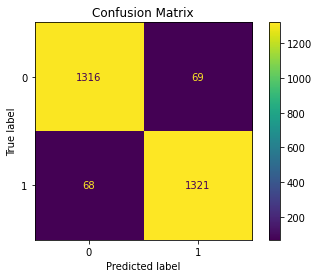

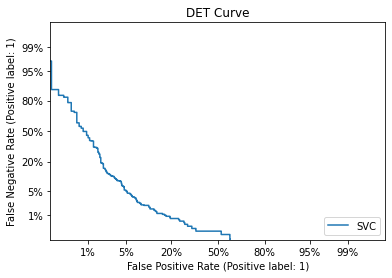

In [ ]:
# kernel = 'linear', filters = 26, c = 1
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n26.csv', test_prc)

lucas = SVC(kernel="linear") 
lucas.fit(x_train, y_train)

linear_score = results_graphs("Linear Kernel", lucas, x_dev, y_dev)

## Polynomial

Polynomial Kernel
Test accuracy: 0.9671953857245854


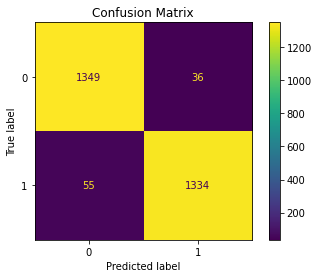

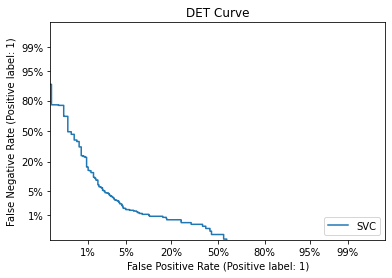

In [ ]:
# kernel = 'poly', filters = 26, c = 1, gamma = 1/(n_features * X.var())
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n26.csv', test_prc)

lucas = SVC(kernel="poly") 
lucas.fit(x_train, y_train)

poly_score = results_graphs("Polynomial Kernel", lucas, x_dev, y_dev)

## **Comparison**

In [ ]:
comp_list = [linear_score, rbf_score, poly_score]
tests_list = ["Linear", "RBF", "Polynomial"]

best_test = tests_list[comp_list.index(max(comp_list))]
print("Best results: " + best_test)

Best results: RBF


# **Test #3** - Grid search

In [ ]:
# Define the paramter grid for C, gamma from 10^-3 to 10^1
C_grid = [0.001, 0.01, 0.1, 1, 10]
gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid, 'gamma' : gamma_grid}

# best case - kernel = 'RBF', filters = 40
# best C and Gamma will calc'd and the model will be refitted
x_train, x_dev, x_test, y_train, y_dev, y_test = get_data('feature_vectors_n40.csv', test_prc)
lucas = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=2, scoring="accuracy", n_jobs=-1)
lucas.fit(x_train, y_train)

# Find the best model
print(lucas.best_params_)

{'C': 10, 'gamma': 0.01}


# **Optimal Model** - Dev set

Dev set
Test accuracy: 0.9808940158615718


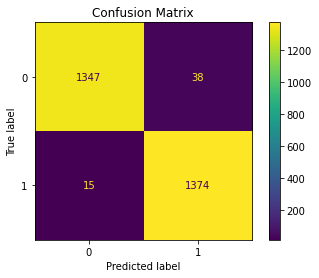

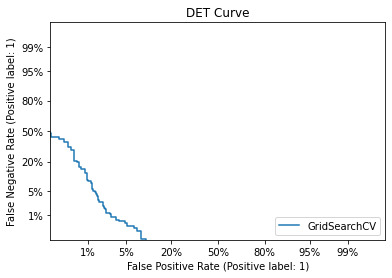

In [ ]:
# Test on dev set
best_dev_score = results_graphs("Dev set", lucas, x_dev, y_dev)

# **Optimal Model** - Test set

Test set
Test accuracy: 0.9747565813198702


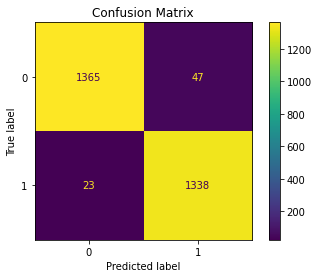

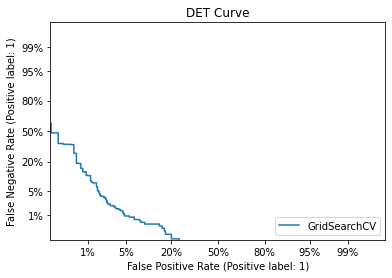

In [ ]:
# Test on test set
test_score = results_graphs("Test set", lucas, x_test, y_test)

In [28]:
%%shell
jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/GenderVoiceRecognition.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/GenderVoiceRecognition.ipynb to PDF
[NbConvertApp] Support files will be in GenderVoiceRecognition_files/
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[NbConvertApp] Making directory ./GenderVoiceRecognition_files
[